In [ ]:
import statistics
import time

import fasttext
import pandas as pd
from dotenv import load_dotenv
from sklearn import metrics
from tqdm import tqdm

import dataloader
import util

load_dotenv()

util.set_seed(22)

In [ ]:
datasets = dataloader.get_domain_data()
eval_datasets = dataloader.get_eval_datasets()
batch_data = dataloader.get_batch_data()

batch_sizes = [1, 32, 64, 128, 256]

# Training

In [ ]:
for domain, dataset in tqdm(datasets.items(), desc='Processing domains'):
    # Convert to pandas DataFrame for consistent access
    train_data = dataset.sample(frac=0.8).reset_index(drop=True)
    test_data = dataset.drop(train_data.index).reset_index(drop=True)

    train_path = 'data/fasttext/train.txt'
    val_path = 'data/fasttext/valid.txt'

    labeled_train = util.label_dataset(train_data)
    labeled_test = util.label_dataset(test_data)

    util.write_to_file(labeled_train, train_path)
    util.write_to_file(labeled_test, val_path)

    actuals = []
    predictions = []
    prediction_times = []

    # fastText
    fasttext_classifier = fasttext.train_supervised(
        input=train_path,
        autotuneValidationFile=val_path,
        autotuneDuration=300,
    )

    train_predictions = []
    for _, row in train_data.iterrows():
        query = str(row["prompt"])
        prediction = fasttext_classifier.predict(query)
        train_predictions.append(1 if prediction[0][0] == "__label__1" else 0)

    train_acc = metrics.accuracy_score(train_data["label"], train_predictions)

    for _, row in tqdm(test_data.iterrows(), total=len(test_data)):
        query = str(row["prompt"])
        start_time = time.perf_counter_ns()
        prediction = fasttext_classifier.predict(query)
        end_time = time.perf_counter_ns()
        prediction_times.append(end_time - start_time)
        predictions.append(1 if prediction[0][0] == "__label__1" else 0)
        actuals.append(row["label"])

    mean_prediction_time = statistics.mean(prediction_times)

    util.evaluate_run(
        predictions=predictions,
        true_labels=actuals,
        domain=domain,
        model_name="fastText",
        embed_model="fastText",
        latency=mean_prediction_time,
        train_acc=train_acc,
        training=True,
    )

    fasttext_classifier.save_model(f"models/fastText_{domain}_fasttext.bin")


# Eval

In [ ]:
fasttext_law = fasttext.load_model("models/fastText_law_fasttext.bin")
fasttext_finance = fasttext.load_model("models/fastText_finance_fasttext.bin")
fasttext_healthcare = fasttext.load_model("models/fastText_healthcare_fasttext.bin")

100%|██████████| 3214/3214 [00:00<00:00, 8976.80it/s]


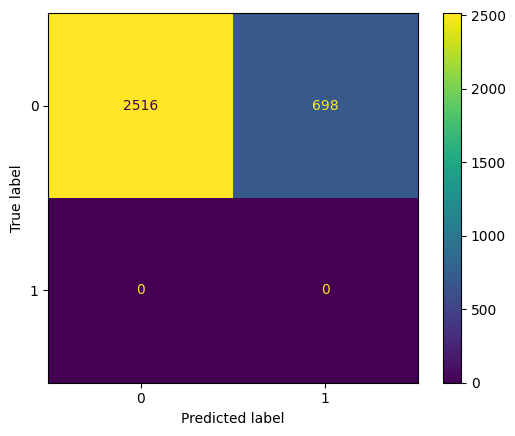

100%|██████████| 860/860 [00:00<00:00, 10016.36it/s]


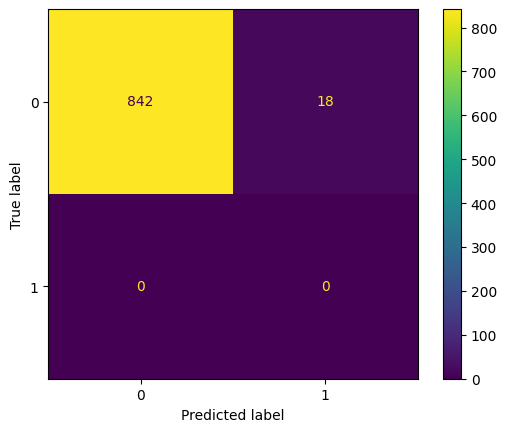

100%|██████████| 5935/5935 [00:00<00:00, 11403.50it/s]


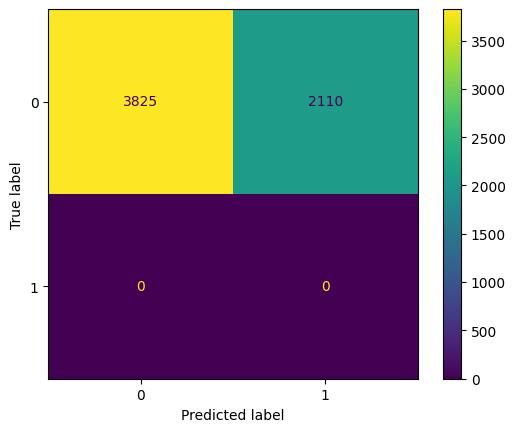

100%|██████████| 959/959 [00:00<00:00, 11095.09it/s]


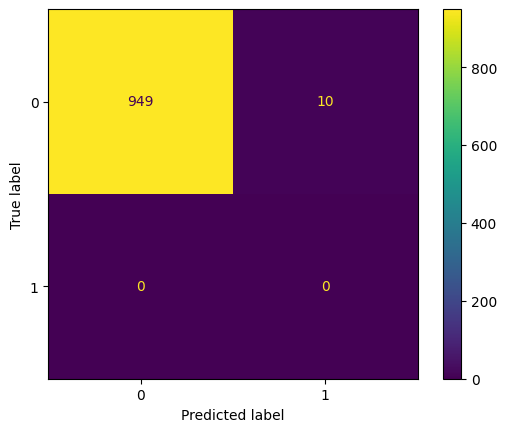

100%|██████████| 329/329 [00:00<00:00, 7205.28it/s]


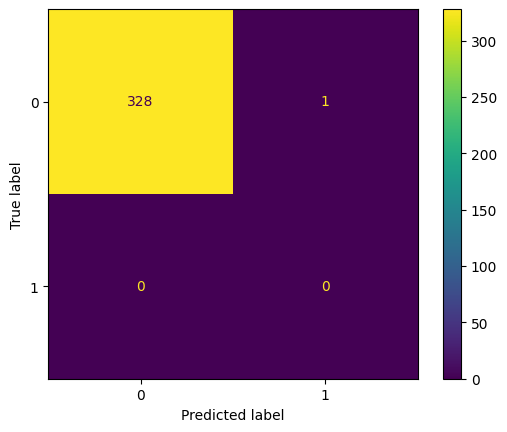

100%|██████████| 2032/2032 [00:00<00:00, 13754.21it/s]


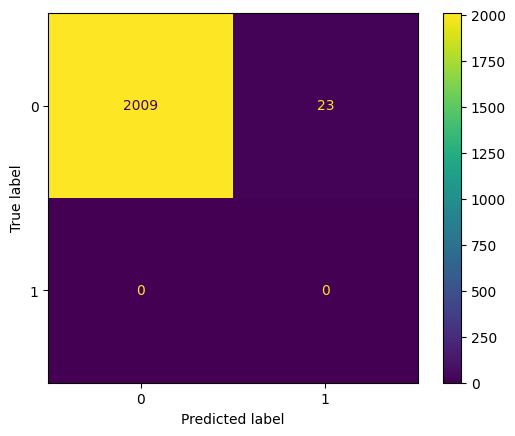

100%|██████████| 128/128 [00:00<00:00, 7300.29it/s]


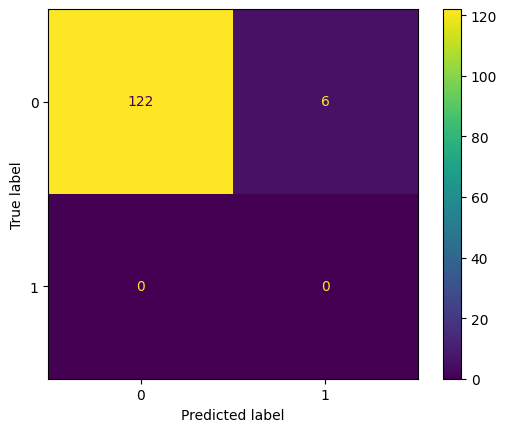

In [7]:
for domain, inference_df in eval_datasets.items():
    actuals_ft = []
    predictions_ft = []
    prediction_times_ft = []

    for _, row in tqdm(inference_df.iterrows(), total=len(inference_df)):
        query = str(row["prompt"]).replace("\n", " ")

        try:
            start_time = time.perf_counter_ns()

            # Predictions from all three classifiers
            prediction_finance = fasttext_finance.predict(query)
            prediction_healthcare = fasttext_healthcare.predict(query)
            prediction_law = fasttext_law.predict(query)

            end_time = time.perf_counter_ns()
            prediction_times_ft.append(end_time - start_time)

            predictions_ft.append(
                0
                if (
                    prediction_finance[0][0] == "__label__1"
                    or prediction_healthcare[0][0] == "__label__1"
                    or prediction_law[0][0] == "__label__1"
                )
                else 1
            )
            actuals_ft.append(row["label"])
        except Exception as e:
            print(f"Error processing row: {e}")
            continue

    util.evaluate_run(
        predictions=predictions_ft,
        true_labels=actuals_ft,
        latency=statistics.mean(prediction_times_ft),
        domain=domain,
        embed_model="fastText",
        model_name="fastText",
        train_acc=0.0,
        cost=0.0,
        training=False,
    )

# Batch 

In [8]:
batch_results = []

for batch_size in tqdm(batch_sizes, desc='Processing batch sizes'):
    all_results = []
    # create batches from batch_data
    batches = [
        batch_data[i : i + batch_size] for i in range(0, len(batch_data), batch_size)
    ]
    for batch in tqdm(batches, desc=f'Processing batches (size={batch_size})'):
        batch_metrics = {
            "time_taken_law": 0,
            "time_taken_finance": 0,
            "time_taken_healthcare": 0
        }

        batch_prompt = [prompt.replace("\n", "") for prompt in batch]

        # Time law predictions
        start_time = time.perf_counter()
        law_preds = fasttext_law.predict(batch_prompt)
        batch_metrics['time_taken_law'] += time.perf_counter() - start_time

        # Time finance predictions
        start_time = time.perf_counter()
        finance_preds = fasttext_finance.predict(batch_prompt)
        batch_metrics['time_taken_finance'] += time.perf_counter() - start_time

        # Time healthcare predictions
        start_time = time.perf_counter()
        health_preds = fasttext_healthcare.predict(batch_prompt)
        batch_metrics['time_taken_healthcare'] += time.perf_counter() - start_time

        results =[]
        for prediction_finance, prediction_healthcare, prediction_law in zip(finance_preds[0], health_preds[0], law_preds[0], strict=True):
                results.append({
                'finance': 1 if prediction_finance[0] == "__label__1" else 0,
                'healthcare': 1 if prediction_healthcare[0] == "__label__1" else 0,
                'law': 1 if prediction_law[0] == "__label__1" else 0
            })

        batch_results.append({
            "batch_size": batch_size,
            "time_taken_embed": 0,
            "time_taken_law": batch_metrics['time_taken_law'],
            "time_taken_finance": batch_metrics['time_taken_finance'],
            "time_taken_healthcare": batch_metrics['time_taken_healthcare'],
            "results": results,
            "model_name": "fasttext",
            "embedding_model": "fasttext",
            "embedding": False
        })

pd.DataFrame(batch_results).to_csv("data/results/batch_fasttext.csv", index=False)

Processing batch sizes: 100%|██████████| 5/5 [00:00<00:00, 37.56it/s]
